In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.signal import correlate, fftconvolve, correlate
from scipy.stats import norm, kendalltau, spearmanr, pearsonr
from scipy.optimize import curve_fit


In [45]:
def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result

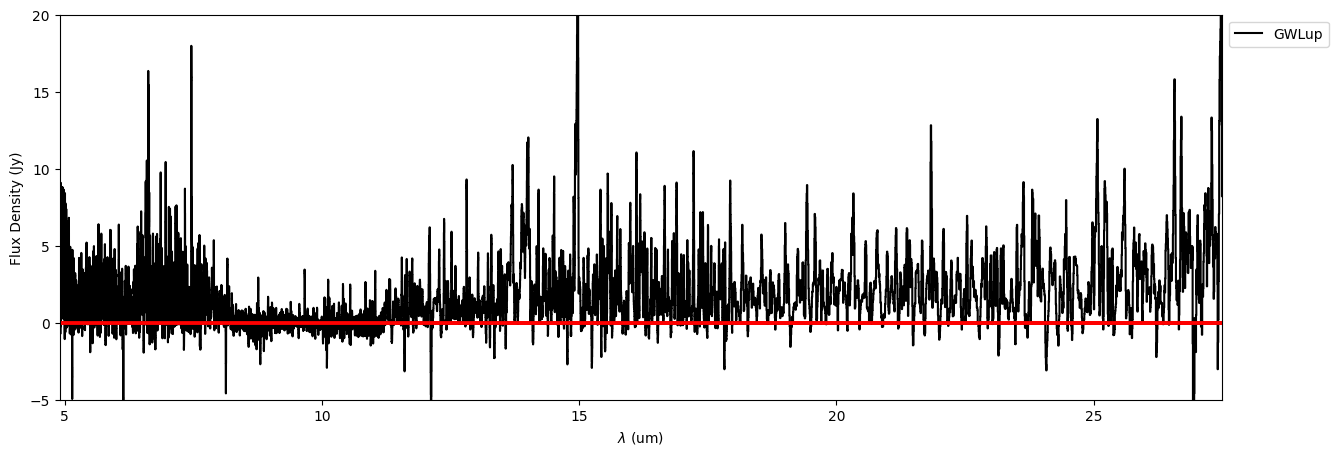

10657


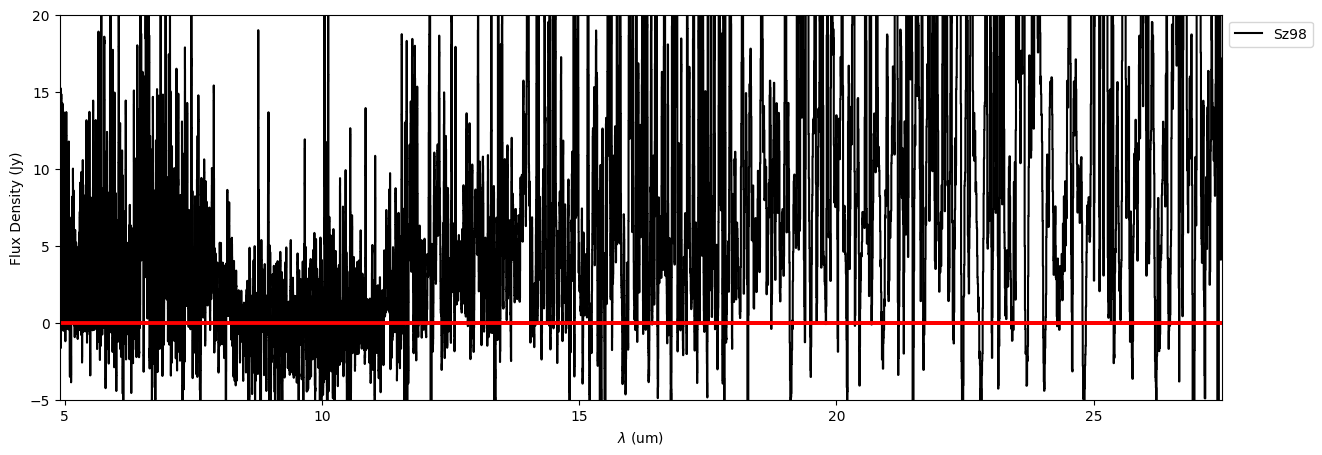

10657


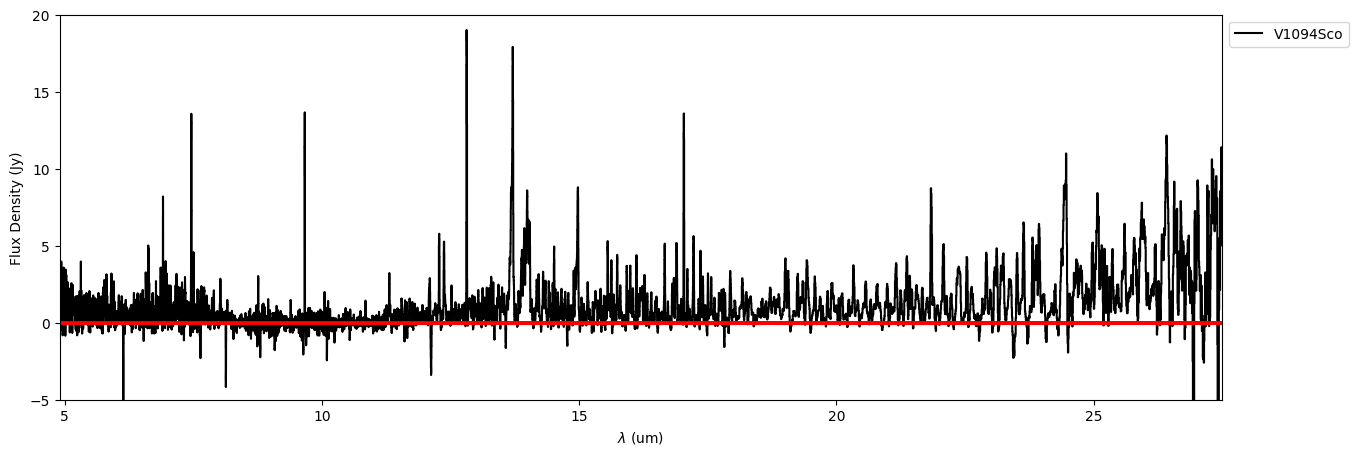

10657


In [2]:
features_df = pd.read_csv("matthias_linelist_combined.csv")

# Wavelength grid
clip_min, clip_max = 4.9, 27.5
feature_mask = np.logical_and(features_df['wavelength'] > clip_min, features_df['wavelength'] < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']

# fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']
    ax1.step(wavelength, np.convolve(flux_cont_sub, np.ones(5)/5, mode='same')*1000, color='black',where='mid', label=f'{Source}')
    for index, row in features_df[feature_mask].iterrows():
        if row['type'] == 'hydrogen':
            color = 'purple'
            offset = 0.05
        elif row['type'] == 'fine_structure':
            color = 'orange'
            offset = 0.4
        elif row['type'] == 'molecular':
            color = 'blue'
            offset = 0.05
        else:
            color = 'red'
            offset = 0.6
        ax1.axhline(0,  color='red')
        # ax1.axvline(row['wavelength'], linestyle='--', alpha=0.3, color=color)
        # ax1.text(row['wavelength']+0.004, offset, row['name'], transform=ax1.get_xaxis_text1_transform(0)[0], color=color, rotation=90)

    # for specie in species:
    #     ax1.plot(total_wl, avg_flux[specie], alpha=0.7, label=specie)

    # plot decorations
    # ax1.set_xticks([14.9, 14.95, 15])
    ax1.set_xlim(clip_min, clip_max)    
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_xlabel(r'$\lambda$ (um)')
    ax1.set_ylim(-5, 20)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    print(len(wavelength))

In [3]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
avg_flux = {}
total_wl = wavelength
for specie in species:
    total_flux = np.zeros_like(total_wl)
    for i,row in df.iterrows():
        specie_wl = row[f'FLiTs {specie} Wavelength']
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_flux = np.interp(total_wl, specie_wl, specie_flux)
        total_flux += specie_flux
    total_flux /= 25
    avg_flux.update({specie:total_flux})

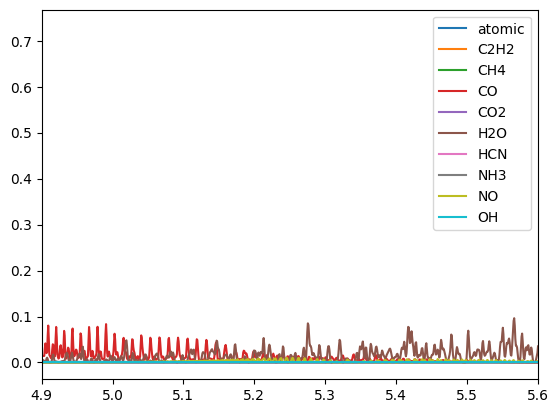

In [5]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie], label=specie)
plt.legend()
plt.xlim(4.9, 5.6)
plt.show()

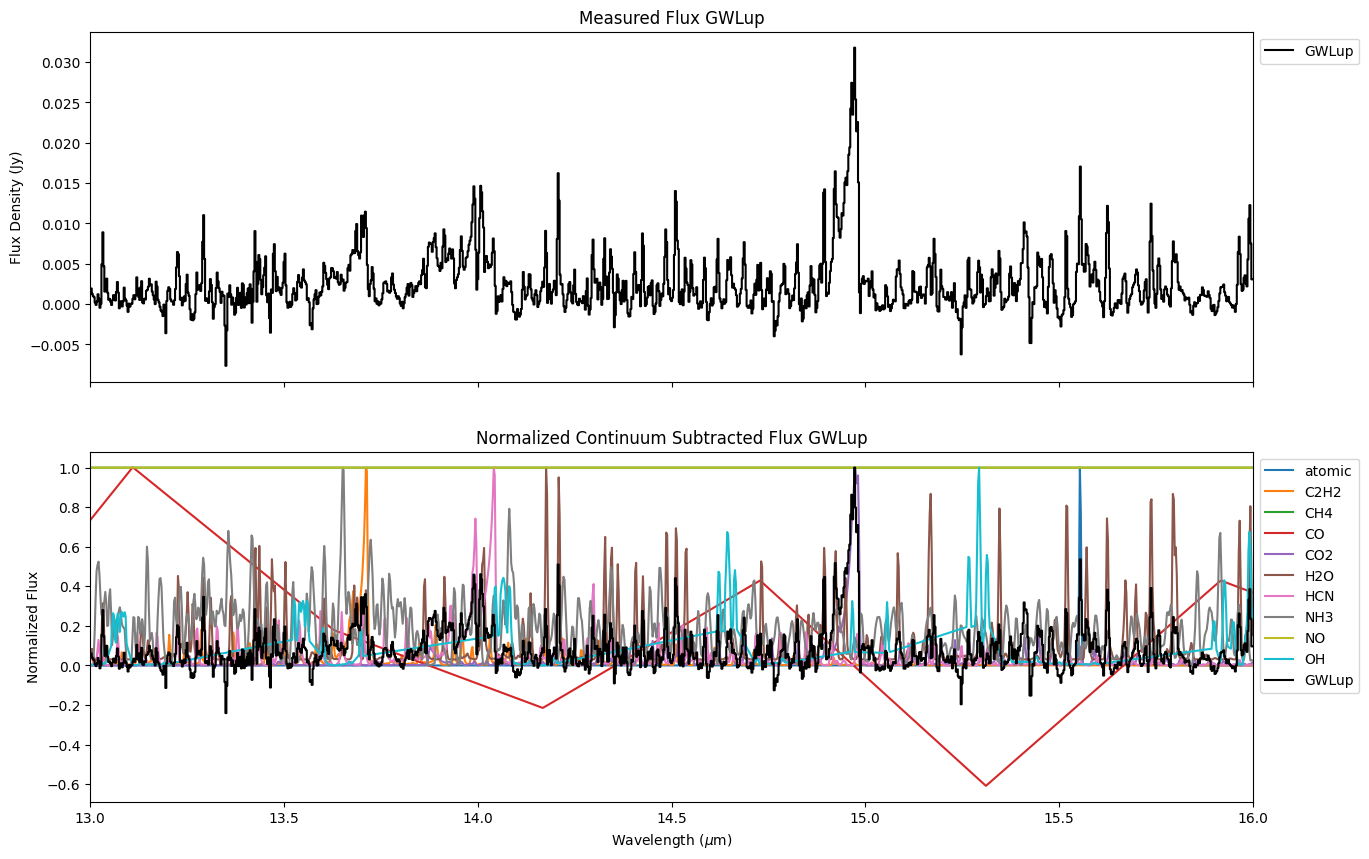

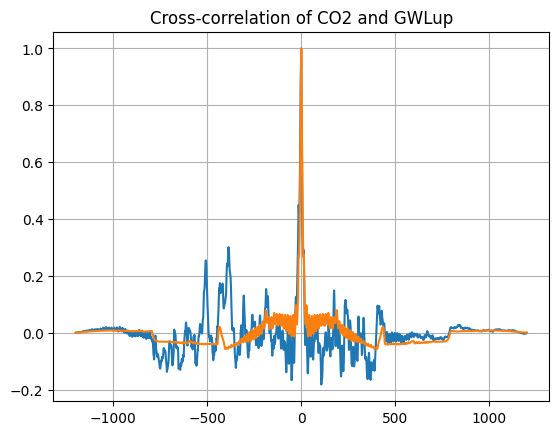

PearsonRResult(statistic=np.float64(0.7094309290404419), pvalue=np.float64(0.0))


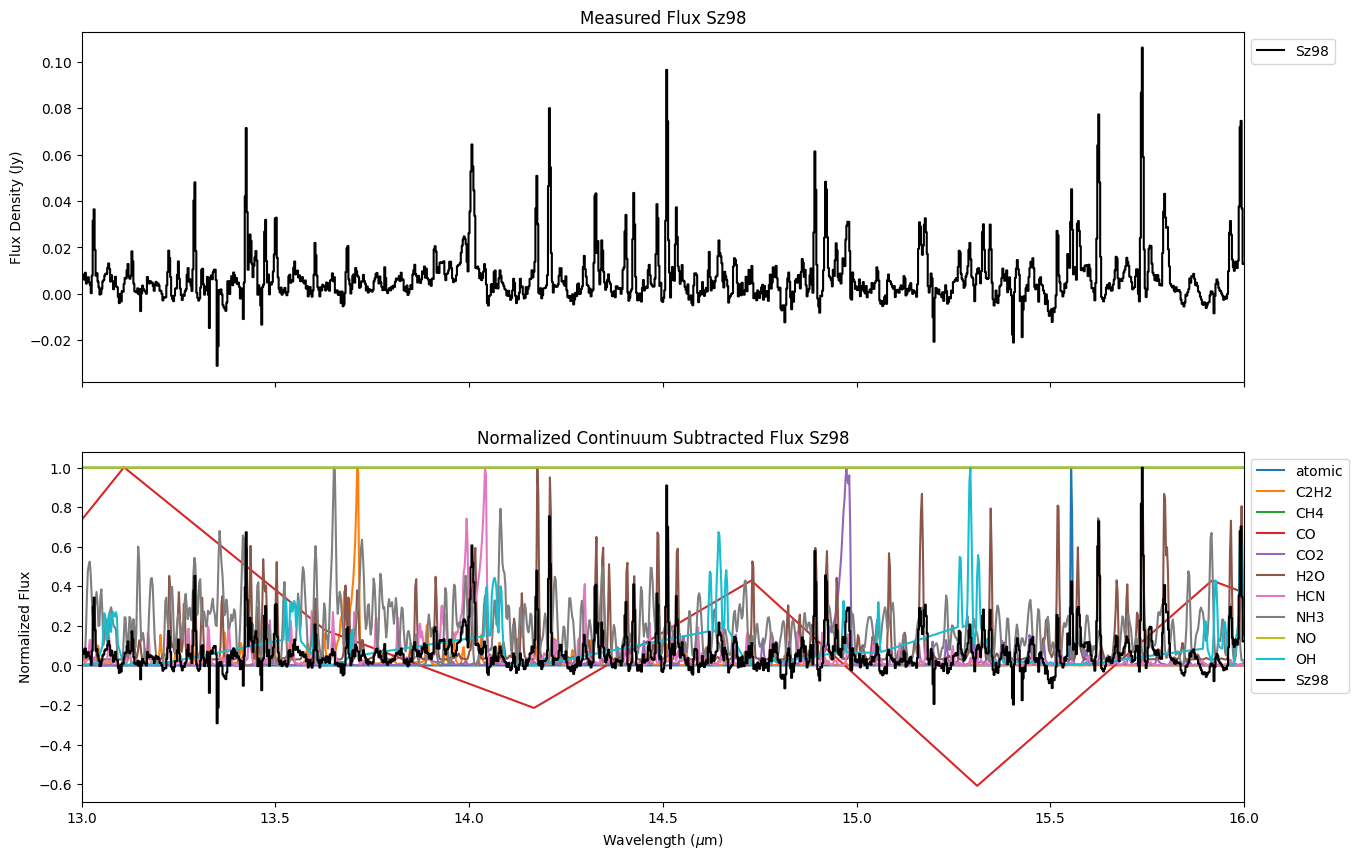

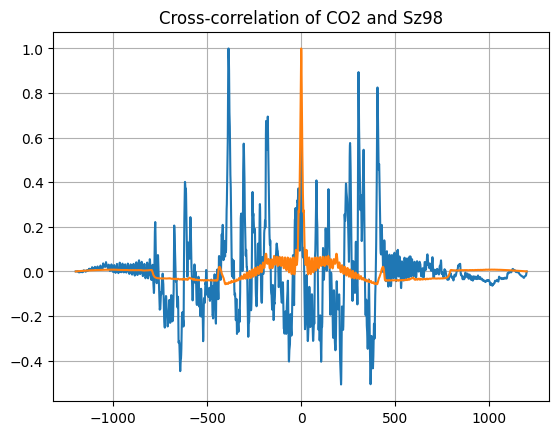

PearsonRResult(statistic=np.float64(0.1401760292171113), pvalue=np.float64(5.231940567801311e-12))


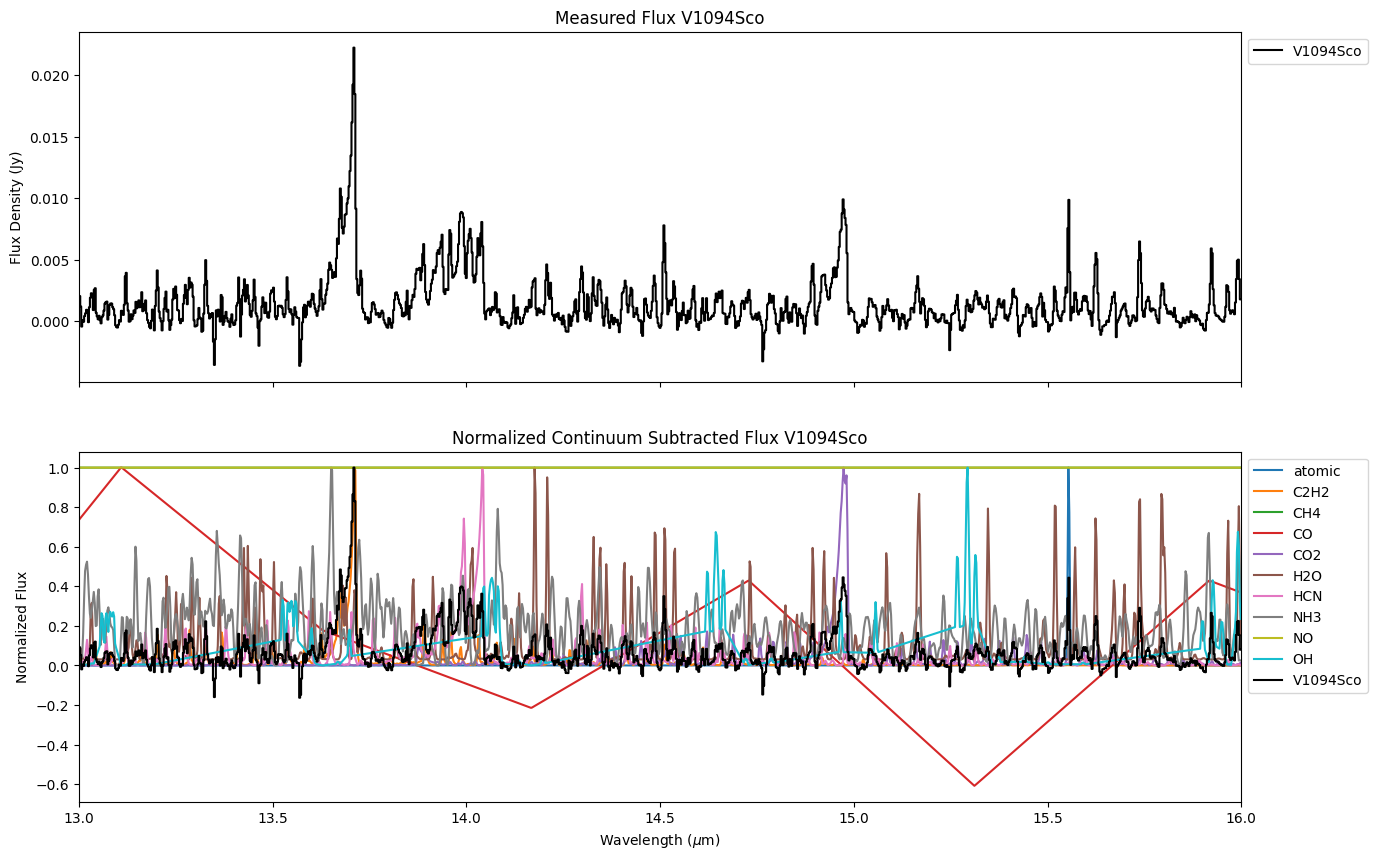

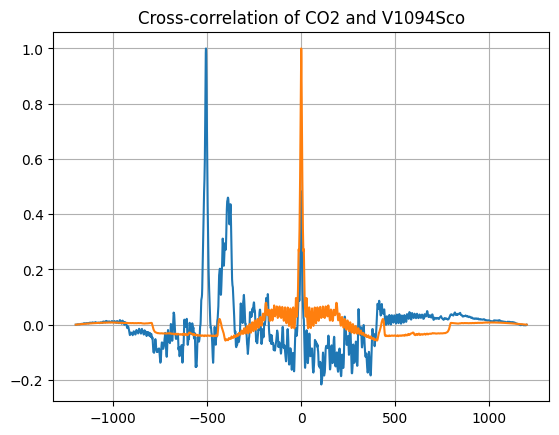

PearsonRResult(statistic=np.float64(0.10392775990908987), pvalue=np.float64(3.331931108511057e-07))


In [106]:
from scipy.optimize import minimize

clip_min, clip_max = 13, 16
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)

species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
# species = ['C2H2', 'H2O', 'HCN', 'NH3', 'OH']
# species = ['NO', 'H2O', 'HCN']


def model(params):
    total = np.zeros_like(total_wl)
    for i, specie in enumerate(species):
        total += params[i] * avg_flux[specie]
    # total += params[-1]
    return total


def loss(params):
    if any(param < 0 for param in params):
        return 1e10
    return np.sum((model(params) - flux_cont_sub)[feature_mask] ** 2)


target = 'CO2'

for Source in ['GWLup', 'Sz98', 'V1094Sco']:
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    result = minimize(loss, [.1] * (len(species)))
    best_params = result.x
    # print(best_params)
    y_fit = model(best_params)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    ax1.step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    ax1.set_xlim(clip_min, clip_max)
    ax1.set_ylabel('Flux Density (Jy)')
    ax1.set_title(f'Measured Flux {Source}')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # plt.show()
    # plt.figure(figsize=(15, 5))
    for specie in species:
        ax2.plot(total_wl[feature_mask], avg_flux[specie][feature_mask] / max(avg_flux[specie][feature_mask]),
                 label=specie)
    ax2.step(wavelength[feature_mask], flux_cont_sub[feature_mask] / max(flux_cont_sub[feature_mask]), color='black',
             label=Source)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.set_xlabel(r'Wavelength ($\mu$m)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title(f'Normalized Continuum Subtracted Flux {Source}')
    plt.show()
    cc = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                     (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1], mode='full')
    ac_specie = fftconvolve((avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask])),
                            (avg_flux[target][feature_mask] - np.mean(avg_flux[target][feature_mask]))[::-1],
                            mode='full')
    ac_total = fftconvolve((flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask])),
                           (flux_cont_sub[feature_mask] - np.mean(flux_cont_sub[feature_mask]))[::-1], mode='full')
    # cc = fftconvolve((flux_cont_sub[feature_mask]),
    #                  (avg_flux[target][feature_mask])[::-1], mode='full')
    # ac_specie = fftconvolve((avg_flux[target][feature_mask]),
    #                         (avg_flux[target][feature_mask])[::-1],
    #                         mode='full')
    # ac_total = fftconvolve((flux_cont_sub[feature_mask]),
    #                        (flux_cont_sub[feature_mask])[::-1], mode='full')
    lags = np.arange(-len(flux_cont_sub[feature_mask]) + 1, len(avg_flux[target][feature_mask]))
    plt.plot(lags, cc/max(cc))
    plt.plot(lags, ac_specie/ac_specie[lags==0])
    plt.title(f'Cross-correlation of {target} and {Source}')
    # plt.xlim(-13, 13)
    plt.grid()
    plt.show()
    print(pearsonr(cc, ac_specie))


Corrected Z-score at lag=0: 11.42
p-value: 0.0000e+00


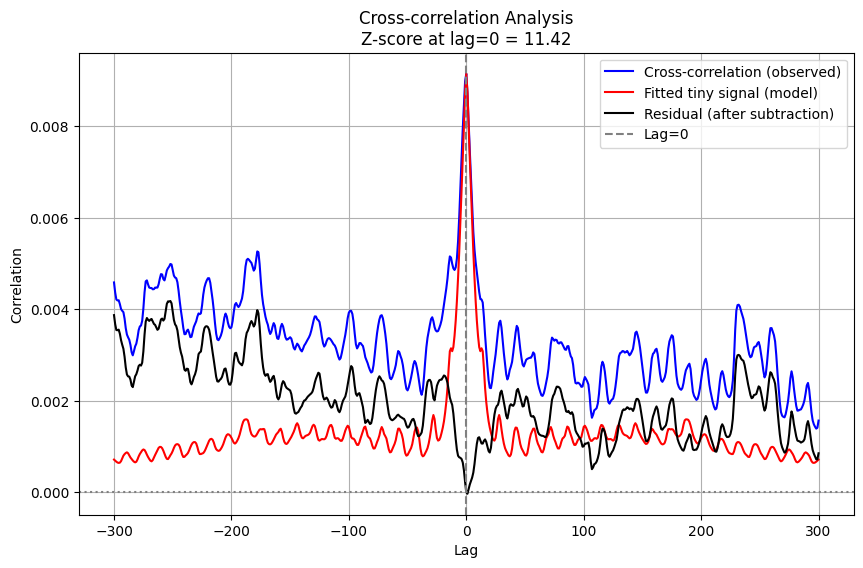

2401
[-300 -299 -298 -297 -296 -295 -294 -293 -292 -291 -290 -289 -288 -287
 -286 -285 -284 -283 -282 -281 -280 -279 -278 -277 -276 -275 -274 -273
 -272 -271 -270 -269 -268 -267 -266 -265 -264 -263 -262 -261 -260 -259
 -258 -257 -256 -255 -254 -253 -252 -251 -250 -249 -248 -247 -246 -245
 -244 -243 -242 -241 -240 -239 -238 -237 -236 -235 -234 -233 -232 -231
 -230 -229 -228 -227 -226 -225 -224 -223 -222 -221 -220 -219 -218 -217
 -216 -215 -214 -213 -212 -211 -210 -209 -208 -207 -206 -205 -204 -203
 -202 -201 -200 -199 -198 -197 -196 -195 -194 -193 -192 -191 -190 -189
 -188 -187 -186 -185 -184 -183 -182 -181 -180 -179 -178 -177 -176 -175
 -174 -173 -172 -171 -170 -169 -168 -167 -166 -165 -164 -163 -162 -161
 -160 -159 -158 -157 -156 -155 -154 -153 -152 -151 -150 -149 -148 -147
 -146 -145 -144 -143 -142 -141 -140 -139 -138 -137 -136 -135 -134 -133
 -132 -131 -130 -129 -128 -127 -126 -125 -124 -123 -122 -121 -120 -119
 -118 -117 -116 -115 -114 -113 -112 -111 -110 -109 -108 -107 -106 -105
 

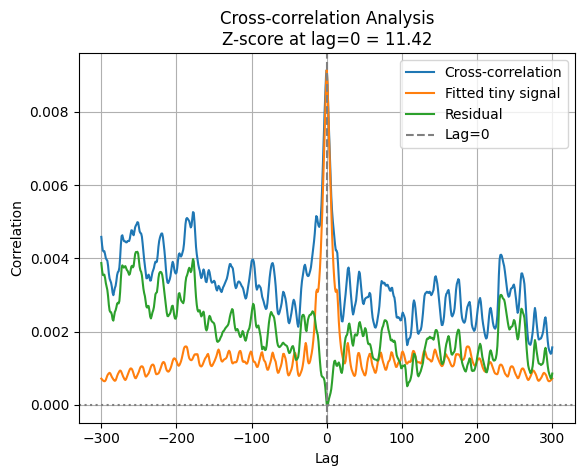

In [143]:
# --- Load your data here ---
# Big_signal: the data containing strong signals + tiny signal + noise
# Tiny_signal: the small signal template you want to find

# Example placeholder (replace these with your real data arrays)
Big_signal = flux_cont_sub[feature_mask]
Tiny_signal = avg_flux[target][feature_mask]

# --- Parameters ---
window = 300   # How far from lag=0 to consider for fitting
exclude = 20   # How many lags around lag=0 to ignore when estimating noise

# --- 1. Compute cross-correlation ---
lags = np.arange(-len(Big_signal) + 1, len(Big_signal))
cross_corr = correlate(Big_signal, Tiny_signal, mode='full')

# --- 2. Compute autocorrelation of tiny signal ---
auto_corr = correlate(Tiny_signal, Tiny_signal, mode='full')
auto_corr = auto_corr / np.max(auto_corr)  # Normalize

# --- 3. Fit autocorrelation to cross-correlation near lag=0 ---
center = len(lags) // 2  # Index corresponding to lag=0
lag_indices = np.arange(center - window, center + window + 1)

X = auto_corr[lag_indices]    # Template (tiny signal autocorrelation)
Y = cross_corr[lag_indices]   # Observed cross-correlation

def model_fn (x,beta):
    shifted_array = shift_array(X, int(round(0)))
    return beta*shifted_array

# Model the expected contribution
popt, pcov = curve_fit(model_fn, lag_indices, Y, p0=[.1])


shift = 0

model = cross_corr[center+shift]*shift_array(X, int(round(shift)))
# Residual
residual = Y - model

# --- 4. Estimate noise standard deviation ---
lags_window = lags[lag_indices] - lags[center]  # Recenter lags around 0

# Mask out ±exclude region around lag=0
noise_mask = (lags_window < -exclude) | (lags_window > exclude)
sigma_noise = np.std(residual[noise_mask])

# --- 5. Calculate Z-score at lag=0 ---
lag0_idx_in_window = np.where(lags_window == 0)[0][0]
Z = cross_corr[center+shift] / sigma_noise

print(f"\nCorrected Z-score at lag=0: {Z:.2f}")
print(f"p-value: {1 - norm.cdf(Z):.4e}")

# --- 6. Plot for visualization ---
plt.figure(figsize=(10,6))
plt.plot(lags_window, Y, label='Cross-correlation (observed)', color='blue')
plt.plot(lags_window, model, label='Fitted tiny signal (model)', color='red')
plt.plot(lags_window, residual, label='Residual (after subtraction)', color='black')
plt.axvline(0, color='gray', linestyle='--', label='Lag=0')
plt.axhline(0, color='gray', linestyle=':')
plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

print(detect_molecule(wavelength, flux_cont_sub, avg_flux[target], clip_min=13, clip_max=16, peak_shift=0, window=300, exclude=20 ))

In [142]:
def shift_array(arr, n, fill_value=0):
    """Shift an array by n elements (left or right)."""
    result = np.empty_like(arr)
    if n > 0:
        result[:n] = fill_value
        result[n:] = arr[:-n]
    elif n < 0:
        result[n:] = fill_value
        result[:n] = arr[-n:]
    else:
        result[:] = arr
    return result


def detect_molecule(wavelength, spectrum, specie_spectrum, clip_min=4.9, clip_max=27.5, peak_shift=0, window=300, exclude=20):
    if len(wavelength) != len(spectrum) | len(wavelength) != len(specie_spectrum):
        print('Error: wavelength, spectrum and specie_spectrum must be the same length')
        return

    feature_mask = np.logical_and(wavelength > clip_min, wavelength < clip_max)

    # center_index = len(wavelength[feature_mask]) // 2

    lags = np.arange(-len(spectrum[feature_mask]) + 1, len(spectrum[feature_mask]))
    cc = correlate(spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac = correlate(specie_spectrum[feature_mask], specie_spectrum[feature_mask], mode='full')
    ac /= ac[len(ac)//2]
    center_index = len(lags) // 2
    lag_indices = np.arange(center_index - window, center_index + window + 1)


    X = ac[lag_indices]
    Y = cc[lag_indices]
    X = shift_array(X, peak_shift)

    print(len(ac))
    model = cc[center_index + peak_shift] * X
    residual = Y - model

    lags_window = lags[lag_indices] - lags[center_index + peak_shift]
    print(lags_window)
    noise_mask = (lags_window < -exclude) | (lags_window > exclude)
    sigma_noise = np.std(residual[noise_mask])

    Z = cc[center_index + peak_shift] / sigma_noise
    p = 1 - norm.cdf(Z)
    plt.plot(lags_window, Y, label='Cross-correlation')
    plt.plot(lags_window, model, label='Fitted tiny signal')
    plt.plot(lags_window, residual, label='Residual')
    plt.axvline(0, color='gray', linestyle='--', label='Lag=0')
    plt.axhline(0, color='gray', linestyle=':')
    plt.title(f'Cross-correlation Analysis\nZ-score at lag=0 = {Z:.2f}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    return Z, p

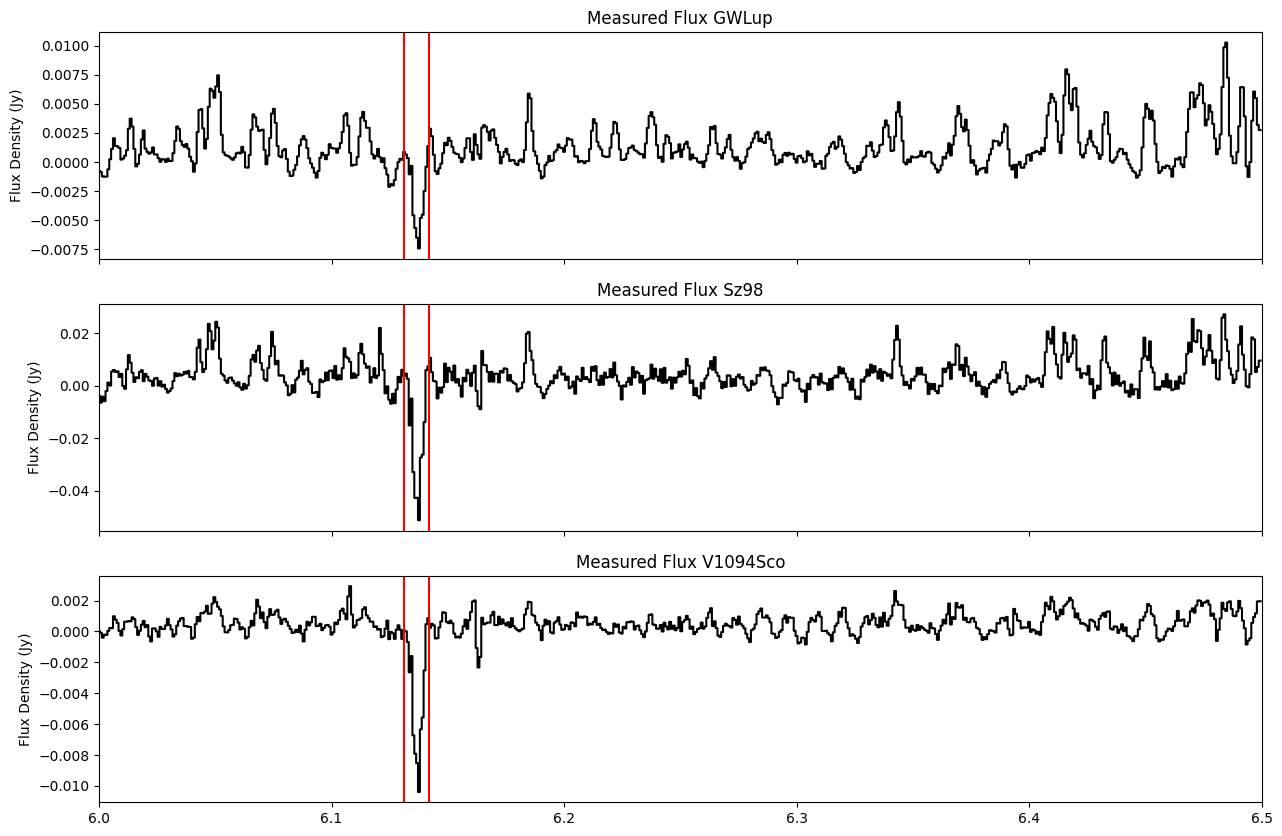

In [153]:
clip_min, clip_max = 6, 6.5
feature_mask = np.logical_and(total_wl > clip_min, total_wl < clip_max)
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux = data['Flux']
    flux_cont_sub = data['CSFlux']
    continuum = data['Baseline']

    # plt.figure(figsize=(15, 5))
    # ax1.plot(wavelength, model(best_params), color='red')
    # for i, specie in enumerate(species):
    #     ax1.plot(total_wl[feature_mask], best_params[i]*avg_flux[specie][feature_mask], alpha=0.7, label=specie)
    axes[i].step(wavelength[feature_mask], flux_cont_sub[feature_mask], color='black', label=Source)
    axes[i].set_xlim(clip_min, clip_max)
    axes[i].set_ylabel('Flux Density (Jy)')
    axes[i].set_title(f'Measured Flux {Source}')
    axes[i].axvline(6.1311, color='red')
    axes[i].axvline(6.1421, color='red')
    # axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()